In [1]:
# Libraries to load
import pandas as pd
import numpy as np 
from scipy import stats
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# data visualization packages 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
pd.set_option('max_columns', None)
import pandas_profiling

# machine learning packages (sklearn + xgboost)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')
np.random.seed(123)

In [2]:
# Load DF
df = pd.read_csv('../data/cleaned_df.csv')

In [3]:
# Format Readmitted
df['readmitted'] = df.readmitted.map({'No':0,'Yes':1})

In [4]:
# Remove Expired or Hospice-bound Patients
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

# Dropping Features

In [5]:
#df = df.drop(columns = ["number_outpatient", "number_emergency", "acetohexamide", "tolbutamide", "miglitol", "troglitazone", "tolazamide",
       #"glipizide-metformin", "metformin-rosiglitazone", "metformin-pioglitazone", "examide", "citoglipton", "diabetesMed"])

#shortest drop list - no patients take these medications
df = df.drop(columns = ["examide", "citoglipton"])

# Feature Engineering

In [6]:
# Change medication to binary take vs not take - play with post model creation

medication = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

#for med in medication:
    #df[med] = df[med].map({'Up':1, 'Down':1, 'Steady':1, 'No':0})

In [7]:
age_id = {'[0-10)':'30 or Under', 
          '[10-20)':'30 or Under', 
          '[20-30)':'30 or Under', 
          '[30-40)':'30 to 60', 
          '[40-50)':'30 to 60', 
          '[50-60)':'30 to 60',
          '[60-70)':'30 to 60', 
          '[70-80)':'Over 60', 
          '[80-90)':'Over 60', 
          '[90-100)':'Over 60'}
df['age'] = df.age.replace(age_id)

In [8]:
# Inspect Unknown/Invalid results for Gender
df[df['gender'].str.contains('Unknown/Invalid')]

race           gender       age  admission_type_id  \
22926    Other  Unknown/Invalid   Over 60                  3   
55129  unknown  Unknown/Invalid  30 to 60                  1   
59490  unknown  Unknown/Invalid   Over 60                  1   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
22926                         1                    1                 1   
55129                         1                    7                 1   
59490                        22                    7                 8   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
22926                   5               5               22                  0   
55129                  38               1                6                  0   
59490                  59               2               21                  0   

       number_emergency  number_inpatient diag_1 diag_2 diag_3  \
22926                 0                 0    414    411    401   
55129                 0                 0    808    873   E813   
59490                 0                 0    850    805    808   

       number_diagnoses max_glu_serum A1Cresult metformin repaglinide  \
22926                 4          None      None        No          No   
55129                 5          None      None        No          No   
59490                 9          None      None    Steady          No   

      nateglinide chlorpropamide glimepiride acetohexamide glipizide  \
22926          No             No          No            No    Steady   
55129          No             No          No            No        No   
59490          No             No          No            No        No   

      glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol  \
22926        No          No       Steady            No       No       No   
55129        No          No           No            No       No       No   
59490        No          No           No        Steady       No       No   

      troglitazone tolazamide insulin glyburide-metformin glipizide-metformin  \
22926           No         No      No                  No                  No   
55129           No         No      No                  No                  No   
59490           No         No      No                  No                  No   

      glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone  \
22926                       No                      No                     No   
55129                       No                      No                     No   
59490                       No                      No                     No   

      change diabetesMed  readmitted  
22926     Ch         Yes           0  
55129     No          No           0  
59490     Ch         Yes           0

In [9]:
# Only 3 values of unknown gender; drop those observations
df = df[df.gender != "Unknown/Invalid"]

In [10]:
# Create a function to group diagnostic codes by range as well as separating diabetes specifically

def diag_grouper(series):
    
    '''takes input as df.col and outputs diagnostic code groupings'''
    
    def no_str(x):
        
        '''takes input as an element of a series and pulls code for diabetes specific disease and E/V categories'''
        
        if '250' in x: return '9999'
        elif 'E' in x: return '123456'
        elif 'V' in x: return '123456'
        elif x == 'missing': return '-654321'
        else: return x
    
    series = series.apply(no_str)
    
    series = series.astype(float)
    
    def num_categ(x):
        
        '''takes input as an element of a series and saves each range as a numerical placeholder'''
        
        if 1 <= x <= 139: return 10000
        elif 140 <= x <= 239: return 10001
        elif 240 <= x <= 279: return 10002
        elif 280 <= x <= 289: return 10003
        elif 290 <= x <= 319: return 10004
        elif 320 <= x <= 359: return 10005
        elif 360 <= x <= 389: return 10006
        elif 390 <= x <= 459 and x == 786: return 10007
        elif 460 <= x <= 519 and x == 787: return 10008
        elif 520 <= x <= 579 and x == 787: return 10009
        elif 580 <= x <= 629 and x == 788: return 10010
        elif 630 <= x <= 679: return 10011
        elif 680 <= x <= 709 and x == 782: return 10012
        elif 710 <= x <= 739: return 10013
        elif 740 <= x <= 759: return 10014
        elif 780 <= x <= 781 and x == 784 and 790 <= x <= 799: return 10015
        elif 800 <= x <= 999: return 10016
        else: return x
        
    series = series.apply(num_categ)
    
    def text_convert(x):
        
        '''takes input as an element of a series and converts each placeholder to string format'''
        
        if x == 10000: return "Other"
        elif x == 10001: return "Neoplasms"
        elif x == 10002: return "Other"
        elif x == 10003: return "Other"
        elif x == 10004: return "Other"
        elif x == 10005: return "Other"
        elif x == 10006: return "Other"
        elif x == 10007: return "Circulatory Disease"
        elif x == 10008: return "Respiratory Disease"
        elif x == 10009: return "Digestive Disease"
        elif x == 10010: return "Genitourinary"
        elif x == 10011: return "Other"
        elif x == 10012: return "Other"
        elif x == 10013: return "Musculoskeletal Disease"
        elif x == 10014: return "Other"
        elif x == 10015: return "Other"
        elif x == 10016: return "Injury and Poisoning"
        elif x == 9999: return "Diabetes"
        elif x == 123456: return "Other"
        elif x == -654321: return "Other"
    
    return series.apply(text_convert)

In [11]:
# Apply diag_grouper to the data frame
df.diag_1 = diag_grouper(df.diag_1)
df.diag_2 = diag_grouper(df.diag_2)
df.diag_3 = diag_grouper(df.diag_3)

In [12]:
## Consolidating Diagnostic Codes Further
# Group Diagnostics By Top 7 Codes (using diag_1 as reference); all other codes as "Other"
df.groupby('diag_1')['diag_1'].count().sort_values(ascending=False)

#modifications to above function

diag_1
Other                      8145
Diabetes                   5748
Injury and Poisoning       4692
Musculoskeletal Disease    4064
Neoplasms                  2538
Name: diag_1, dtype: int64

In [13]:
# Create boolean masks for the columns in question

Circ = df[['diag_1','diag_2','diag_3']].isin(['Circulatory Disease']).astype(int)
Resp = df[['diag_1','diag_2','diag_3']].isin(['Respiratory Disease']).astype(int)
Digest = df[['diag_1','diag_2','diag_3']].isin(['Digestive Disease']).astype(int)
Diab = df[['diag_1','diag_2','diag_3']].isin(['Diabetes']).astype(int)
Genit = df[['diag_1','diag_2','diag_3']].isin(['Genitourinary']).astype(int)
Muscu = df[['diag_1','diag_2','diag_3']].isin(['Musculoskeletal Disease']).astype(int)
Neop = df[['diag_1','diag_2','diag_3']].isin(['Neoplasms']).astype(int)
Inj = df[['diag_1','diag_2','diag_3']].isin(['Injury and Poisoning']).astype(int)
Othr = df[['diag_1','diag_2','diag_3']].isin(['Other']).astype(int)

In [14]:
Circulatory = (Circ['diag_1'] + Circ['diag_2'] + Circ['diag_3'])
Respiratory = Resp['diag_1'] + Resp['diag_2'] + Resp['diag_3']
Digestive = Digest['diag_1'] + Digest['diag_2'] + Digest['diag_3']
Diabetes = Diab['diag_1'] + Diab['diag_2'] + Diab['diag_3']
Injury = Inj['diag_1'] + Inj['diag_2'] + Inj['diag_3']
Genitourinary = Genit['diag_1'] + Genit['diag_2'] + Genit['diag_3']
Musculoskeletal = Muscu['diag_1'] + Muscu['diag_2'] + Muscu['diag_3']
Neoplasms = Neop['diag_1'] + Neop['diag_2'] + Neop['diag_3']
Other = Othr['diag_1'] + Othr['diag_2'] + Othr['diag_3']

In [15]:
newcollist = [Circulatory, Respiratory, Digestive, Diabetes, Injury, Genitourinary, Musculoskeletal, Neoplasms, Other]

In [16]:
newcols = pd.concat(newcollist, axis = 1)
newcols.columns = ['diag_Circulatory', 'diag_Respiratory', 'diag_Digestive', 'diag_Diabetes', 'diag_Injury',
                   'diag_Genitourinary', 'diag_Musculoskeletal', 'diag_Neoplasms','diag_Other']
newcols = newcols.astype(bool).astype(int)

In [17]:
df = df.drop(columns = ['diag_1','diag_2','diag_3'])
df = pd.concat([df,newcols],axis=1)

In [18]:
df

race  gender          age  admission_type_id  \
0            Caucasian  Female  30 or Under                  6   
1            Caucasian  Female  30 or Under                  1   
2      AfricanAmerican  Female  30 or Under                  1   
3            Caucasian    Male     30 to 60                  1   
4            Caucasian    Male     30 to 60                  1   
...                ...     ...          ...                ...   
71513        Caucasian  Female      Over 60                  1   
71514            Other  Female     30 to 60                  1   
71515            Other  Female     30 to 60                  1   
71516        Caucasian  Female      Over 60                  1   
71517        Caucasian    Male      Over 60                  1   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
0                            25                    1                 1   
1                             1                    7                 3   
2                             1                    7                 2   
3                             1                    7                 2   
4                             1                    7                 1   
...                         ...                  ...               ...   
71513                         1                    7                 9   
71514                         1                    7                14   
71515                         1                    7                 2   
71516                         1                    7                 5   
71517                         1                    7                 6   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0                      41               0                1                  0   
1                      59               0               18                  0   
2                      11               5               13                  2   
3                      44               1               16                  0   
4                      51               0                8                  0   
...                   ...             ...              ...                ...   
71513                  50               2               33                  0   
71514                  73               6               26                  0   
71515                  46               6               17                  1   
71516                  76               1               22                  0   
71517                  13               3                3                  0   

       number_emergency  number_inpatient  number_diagnoses max_glu_serum  \
0                     0                 0                 1          None   
1                     0                 0                 9          None   
2                     0                 1                 6          None   
3                     0                 0                 7          None   
4                     0                 0                 5          None   
...                 ...               ...               ...           ...   
71513                 0                 0                 9          None   
71514                 1                 0                 9          None   
71515                 1                 1                 9          None   
71516                 1                 0                 9          None   
71517                 0                 0                 9          None   

      A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0          None        No          No          No             No          No   
1          None        No          No          No             No          No   
2          None        No          No          No             No          No   
3          None        No          No          No             No          No   
4          None        No          No 

# Separation for Scaling and Encoding

In [19]:
# for medication in simplified binary
# categorical = df.drop(columns = ['time_in_hospital',
#        'num_lab_procedures', 'num_procedures', 'num_medications',
#        'number_outpatient', 'number_emergency', 'number_inpatient',
#         'number_diagnoses', 'diag_Circulatory', 'diag_Respiratory',
#        'diag_Digestive', 'diag_Diabetes', 'diag_Neoplasms', 'diag_Injury', 
#        'diag_Genitourinary', 'diag_Musculoskeletal',  
#         'diag_Other','metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
#        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
#        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
#        'tolazamide', 'insulin',
#        'glyburide-metformin', 'glipizide-metformin',
#        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
#        'metformin-pioglitazone','readmitted'])
# numerical = df.drop(columns = ['race', 'gender', 'age', 'admission_type_id',
#        'discharge_disposition_id', 'admission_source_id', 
#        'max_glu_serum', 'A1Cresult', 'diag_Circulatory', 'diag_Respiratory',
#        'diag_Digestive', 'diag_Diabetes', 'diag_Injury', 'diag_Other',                        
#        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
#        'diag_Genitourinary', 'diag_Musculoskeletal', 'diag_Neoplasms',
#        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
#        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
#        'tolazamide', 'insulin',
#        'glyburide-metformin', 'glipizide-metformin',
#        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
#        'metformin-pioglitazone', 'change', 'diabetesMed','readmitted'])

# for medication in original form
categorical = df.drop(columns = ['time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
        'number_diagnoses', 'diag_Circulatory', 'diag_Respiratory',
       'diag_Digestive', 'diag_Diabetes', 'diag_Neoplasms', 'diag_Injury', 
       'diag_Genitourinary', 'diag_Musculoskeletal',  
        'diag_Other','readmitted'])
numerical = df.drop(columns = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 
       'max_glu_serum', 'A1Cresult', 'diag_Circulatory', 'diag_Respiratory',
       'diag_Digestive', 'diag_Diabetes', 'diag_Injury', 'diag_Other',                        
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'diag_Genitourinary', 'diag_Musculoskeletal', 'diag_Neoplasms',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','readmitted'])

In [20]:
# Separation of features from target for dummification

X = df.drop('readmitted', axis = 1)
y = df['readmitted']

In [21]:
X = pd.get_dummies(X, columns = categorical.columns)

#### Recombine data frame for 80/20 split

In [22]:
df = X.assign(readmitted = y)

In [23]:
# Perform and 80/20 split of the data
X = df.drop('readmitted', axis = 1)
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123)

In [24]:
X_train[numerical.columns] = StandardScaler().fit_transform(X_train[numerical.columns])

In [25]:
X_train

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
20234         -0.775219            0.156005        0.894402        -0.320751   
47385          0.927909            0.356968       -0.243789        -0.079393   
6359          -0.434594            0.608172       -0.812885        -0.320751   
14545          0.587284            0.256487       -0.243789        -0.320751   
40091         -0.093968            0.356968       -0.812885         0.403322   
...                 ...                 ...             ...              ...   
5991           0.927909            0.206246        0.325306        -0.200072   
18999         -0.093968            0.708653       -0.243789        -0.320751   
5161           1.268535            1.060339        1.463498         1.248074   
53209         -0.093968            0.055524        1.463498         1.489431   
6118           2.631038            2.165635        0.894402         0.765358   

       number_outpatient  number_emergency  number_inpatient  \
20234          -0.261541         -0.208202         -0.291784   
47385          -0.261541          1.815117         -0.291784   
6359           -0.261541         -0.208202         -0.291784   
14545          -0.261541         -0.208202          6.295384   
40091          -0.261541         -0.208202          1.355008   
...                  ...               ...               ...   
5991           -0.261541         -0.208202         -0.291784   
18999          -0.261541         -0.208202         -0.291784   
5161           -0.261541         -0.208202         -0.291784   
53209          -0.261541          7.885075         -0.291784   
6118            0.677041         -0.208202          1.355008   

       number_diagnoses  diag_Circulatory  diag_Respiratory  diag_Digestive  \
20234         -1.110856                 0                 0               0   
47385          0.889297                 0                 0               0   
6359           0.889297                 0                 0               0   
14545          0.389259                 0                 0               0   
40091          0.889297                 0                 0               0   
...                 ...               ...               ...             ...   
5991           0.889297                 0                 0               0   
18999         -1.110856                 0                 0               0   
5161          -0.110779                 0                 0               0   
53209          0.889297                 0                 0               0   
6118           0.889297                 0                 0               0   

       diag_Diabetes  diag_Injury  diag_Genitourinary  diag_Musculoskeletal  \
20234              0            0                   0                     0   
47385              1            0                   0                     0   
6359               0            0                   0                     0   
14545              1            0                   0                     1   
40091              0            0                   0                     0   
...              ...          ...                 ...                   ...   
5991               1            0                   0                     0   
18999              0            0                   0                     0   
5161               0            0                   0                     0   
53209              0            1                   0                     0   
6118               0            1                   0                     0   

       diag_Neoplasms  diag_Other  race_AfricanAmerican  race_Asian  \
20234               0           0                     0           0   
47385               0           1                     1           0   
6359                0           0                     0           0   
14545               0           0                     0           0   
40091               0   

# Balancing the Data Set

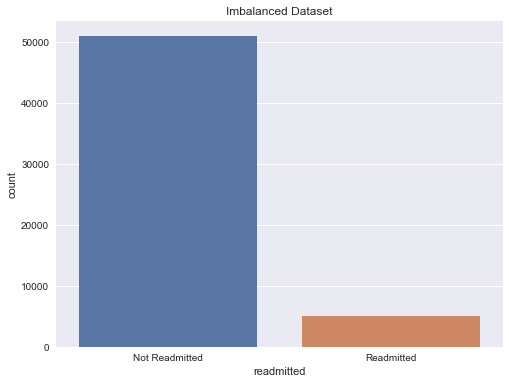

In [26]:
plt.figure(figsize=(8,6))
sns.countplot(y_train, palette='deep')
sns.despine()
plt.title('Imbalanced Dataset')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'])
plt.show()

In [27]:
# SMOTE 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=123)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

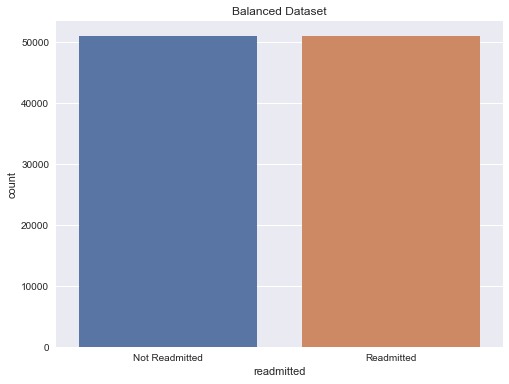

In [28]:
plt.figure(figsize=(8,6))
sns.countplot(y_train_res, palette='deep')
sns.despine()
plt.title('Balanced Dataset')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'])
plt.show()

## Model Base Line

In [29]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [30]:
thresh = 0.5

## Logistic regression

In [31]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 123)
lr.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [32]:
y_train_preds = lr.predict_proba(X_train)[:,1]
y_valid_preds = lr.predict_proba(X_test)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Test:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_test,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.655
accuracy:0.910
recall:0.006
precision:0.446
specificity:0.999
prevalence:0.090
 
Test:
AUC:0.587
accuracy:0.457
recall:0.668
precision:0.105
specificity:0.436
prevalence:0.090
 
